<a href="https://colab.research.google.com/github/MuhametshaKakayev/PneumaniaInceptionV3/blob/main/Guncel_%22Phenmon%C4%B1aXray%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!rm -rf /content/*

In [5]:
# 1. Kaggle API’yı kur
!pip install --quiet kaggle

# 2. Kaggle JSON dosyanı doğru yere kopyala
import os
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
os.replace('/content/kaggle(1).json', os.path.expanduser('~/.kaggle/kaggle.json'))
os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)

# 3. Veri setini indir ve aç
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content --unzip

# 4. Ana klasör yolunu belirt ve yapıyı göster
base_dir = '/content/chest_xray'
print("Klasör yapısı:")
!find $base_dir -maxdepth 2 -type d

# 5. TÜM veri setini (örneklemeden) yeni klasöre kopyala
import shutil

full_dir = '/content/chest_xray_full'

for split in ['train', 'val', 'test']:
    for cls in ['NORMAL', 'PNEUMONIA']:
        src = os.path.join(base_dir, split, cls)
        dst = os.path.join(full_dir, split, cls)
        os.makedirs(dst, exist_ok=True)

        files = os.listdir(src)
        for f in files:
            shutil.copy(os.path.join(src, f), os.path.join(dst, f))

print("Tüm veri seti başarıyla kopyalandı:", full_dir)


# 6. Küçük klasörü zip’le ve bilgisayarına indir
#import shutil
#from google.colab import files

#zip_path = '/content/chest_xray_small.zip'
#shutil.make_archive('/content/chest_xray_small', 'zip', small_dir)
#files.download(zip_path)


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:27<00:00, 36.8MB/s]
100% 2.29G/2.29G [00:28<00:00, 87.9MB/s]
Klasör yapısı:
/content/chest_xray
/content/chest_xray/val
/content/chest_xray/val/PNEUMONIA
/content/chest_xray/val/NORMAL
/content/chest_xray/test
/content/chest_xray/test/PNEUMONIA
/content/chest_xray/test/NORMAL
/content/chest_xray/chest_xray
/content/chest_xray/chest_xray/val
/content/chest_xray/chest_xray/test
/content/chest_xray/chest_xray/train
/content/chest_xray/__MACOSX
/content/chest_xray/__MACOSX/chest_xray
/content/chest_xray/train
/content/chest_xray/train/PNEUMONIA
/content/chest_xray/train/NORMAL
Tüm veri seti başarıyla kopyalandı: /content/chest_xray_full


In [6]:
import os
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import random
import shutil

full_dir = '/content/chest_xray_full'  # Orijinal tüm veri seti klasörü
balanced_dir = '/content/chest_xray_balanced'

val_split_ratio = 0.15  # %15 validation ayır

# Klasörleri hazırla
for split in ['train', 'val', 'test']:
    for cls in ['NORMAL', 'PNEUMONIA']:
        os.makedirs(os.path.join(balanced_dir, split, cls), exist_ok=True)

# Test ve orijinal val klasörünü olduğu gibi kopyala
for split in ['val', 'test']:
    for cls in ['NORMAL', 'PNEUMONIA']:
        src = os.path.join(full_dir, split, cls)
        dst = os.path.join(balanced_dir, split, cls)
        for f in os.listdir(src):
            shutil.copy2(os.path.join(src, f), os.path.join(dst, f))

# Train içinden validation ayır ve train setini dengele
normal_train_files = []
pneumonia_train_files = []

for cls in ['NORMAL', 'PNEUMONIA']:
    src_train = os.path.join(full_dir, 'train', cls)
    files = os.listdir(src_train)
    random.shuffle(files)

    val_count = int(len(files) * val_split_ratio)
    val_files = files[:val_count]
    train_files = files[val_count:]

    # Validation dosyalarını kopyala
    for f in val_files:
        shutil.copy2(os.path.join(src_train, f), os.path.join(balanced_dir, 'val', cls, f))

    # Train dosyalarını listele (daha sonra dengeleme için)
    if cls == 'NORMAL':
        normal_train_files = train_files
    else:
        pneumonia_train_files = train_files

# Validation setini dengele
normal_val_path = os.path.join(balanced_dir, 'val', 'NORMAL')
pneumonia_val_path = os.path.join(balanced_dir, 'val', 'PNEUMONIA')

normal_val_files = os.listdir(normal_val_path)
pneumonia_val_files = os.listdir(pneumonia_val_path)

# PNEUMONIA sayısını NORMAL sayısına indir
pneumonia_val_sample = random.sample(pneumonia_val_files, min(len(pneumonia_val_files), len(normal_val_files)))

# Fazla validation dosyalarını sil
for f in pneumonia_val_files:
    if f not in pneumonia_val_sample:
        os.remove(os.path.join(pneumonia_val_path, f))

print("Validation seti dengelendi.")

# Train setini dengele: PNEUMONIA sayısını NORMAL sayısına indir
pneumonia_train_sample = random.sample(pneumonia_train_files, min(len(pneumonia_train_files), len(normal_train_files)))

# Train dosyalarını kopyala
for f in normal_train_files:
    shutil.copy2(os.path.join(full_dir, 'train', 'NORMAL', f), os.path.join(balanced_dir, 'train', 'NORMAL', f))

for f in pneumonia_train_sample:
    shutil.copy2(os.path.join(full_dir, 'train', 'PNEUMONIA', f), os.path.join(balanced_dir, 'train', 'PNEUMONIA', f))

print("Train seti dengelendi, validation ayrıldı ve yeni klasöre kopyalandı:", balanced_dir)

# Klasör içeriğini say ve yazdır
splits = ['train', 'val', 'test']
classes = ['NORMAL', 'PNEUMONIA']

for split in splits:
    print(f"\n--- {split.upper()} ---")
    for cls in classes:
        path = os.path.join(balanced_dir, split, cls)
        if os.path.exists(path):
            count = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
            print(f"{cls}: {count} görüntü")
        else:
            print(f"{cls}: klasör bulunamadı")


Validation seti dengelendi.
Train seti dengelendi, validation ayrıldı ve yeni klasöre kopyalandı: /content/chest_xray_balanced

--- TRAIN ---
NORMAL: 1140 görüntü
PNEUMONIA: 1140 görüntü

--- VAL ---
NORMAL: 209 görüntü
PNEUMONIA: 209 görüntü

--- TEST ---
NORMAL: 234 görüntü
PNEUMONIA: 390 görüntü


Found 2280 images belonging to 2 classes.
Found 418 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 22,065,185 (84.17 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6680 - loss: 0.5981

25/25 ━━━━━━━━━━━━━━━━━━━━ 150s 6s/step - accuracy: 0.6713 - loss: 0.5948 - val_accuracy: 0.8500 - val_loss: 0.4360
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8703 - loss: 0.3476

25/25 ━━━━━━━━━━━━━━━━━━━━ 143s 6s/step - accuracy: 0.8714 - loss: 0.3465 - val_accuracy: 0.8562 - val_loss: 0.3714
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - accuracy: 0.9053 - loss: 0.2775 - val_accuracy: 0.8438 - val_loss: 0.3302
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9200 - loss: 0.2415

25/25 ━━━━━━━━━━━━━━━━━━━━ 203s 8s/step - accuracy: 0.9187 - loss: 0.2433 - val_accuracy: 0.9125 - val_loss: 0.2910
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 135s 5s/step - accuracy: 0.8924 - loss: 0.2600 - val_accuracy: 0.8625 - val_loss: 0.3240
Epoch 6/10
18/25 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.9129 - loss: 0.2451

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


25/25 ━━━━━━━━━━━━━━━━━━━━ 143s 6s/step - accuracy: 0.9198 - loss: 0.2348 - val_accuracy: 0.9250 - val_loss: 0.2610
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 200s 7s/step - accuracy: 0.8948 - loss: 0.2844 - val_accuracy: 0.8875 - val_loss: 0.2772
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 143s 6s/step - accuracy: 0.9061 - loss: 0.2377 - val_accuracy: 0.9250 - val_loss: 0.2296
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9103 - loss: 0.2370

25/25 ━━━━━━━━━━━━━━━━━━━━ 136s 6s/step - accuracy: 0.9100 - loss: 0.2376 - val_accuracy: 0.9312 - val_loss: 0.2110
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8961 - loss: 0.2701

25/25 ━━━━━━━━━━━━━━━━━━━━ 137s 6s/step - accuracy: 0.8963 - loss: 0.2692 - val_accuracy: 0.9563 - val_loss: 0.2125
39/39 ━━━━━━━━━━━━━━━━━━━━ 148s 4s/step - accuracy: 0.7193 - loss: 0.5455

Test Accuracy: 82.85%
39/39 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step
🔍 Confusion Matrix:
[[149  85]
 [ 22 368]]

📄 Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.87      0.64      0.74       234
   PNEUMONIA       0.81      0.94      0.87       390

    accuracy                           0.83       624
   macro avg       0.84      0.79      0.80       624
weighted avg       0.83      0.83      0.82       624

Accuracy:    0.8285
Precision:   0.8124
Recall:      0.9436
Specificity:0.6368
F1 Score:    0.8731


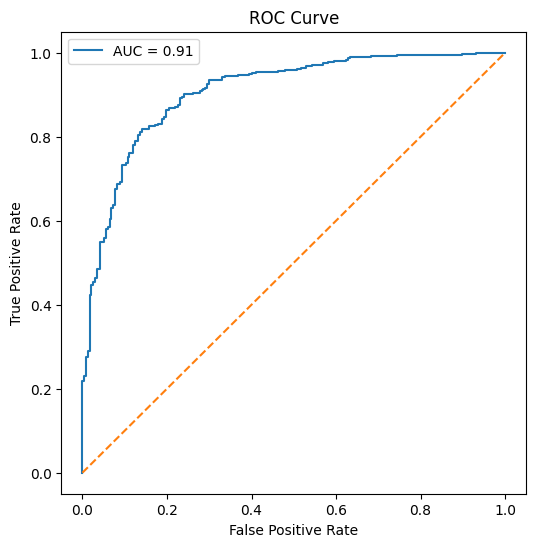

In [11]:
# 2. Data generator'lar
train_dir = '/content/chest_xray_balanced/train'  # Kendi eğitim veri klasörünüzün yolu
val_dir = '/content/chest_xray_balanced/val'      # Doğrulama veri klasörü
test_dir = '/content/chest_xray_balanced/test'    # Test veri klasörü

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_it = train_gen.flow_from_directory(
    train_dir, target_size=(299,299), batch_size=16, class_mode='binary')
val_it = val_gen.flow_from_directory(
    val_dir,   target_size=(299,299), batch_size=16, class_mode='binary')
test_it = test_gen.flow_from_directory(
    test_dir,  target_size=(299,299), batch_size=16, class_mode='binary', shuffle=False)

# 3. InceptionV3 taban model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=preds)

# 4. Sadece üst katmanları eğit
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# 5. Callbacks
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')
earlystop  = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# 6. Modeli eğit
steps_per_epoch = 25  # veya 100
validation_steps = 10  # val için benzer şekilde

history = model.fit(
    train_it,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_it,
    validation_steps=validation_steps,
    callbacks=[checkpoint, earlystop]
)
# 7. Test setinde değerlendir
loss, acc = model.evaluate(test_it)
print(f"\nTest Accuracy: {acc*100:.2f}%")

import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)

# 1. Test setindeki gerçek ve olasılık tahminleri
y_true = test_it.classes
y_prob = model.predict(test_it).ravel()
y_pred = (y_prob > 0.5).astype(int)

# 2. Confusion Matrix ve temel metrikler
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

accuracy  = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if tp+fp>0 else 0
recall    = tp / (tp + fn) if tp+fn>0 else 0   # sensitivity
specificity = tn / (tn + fp) if tn+fp>0 else 0
f1        = 2 * (precision * recall) / (precision + recall) if precision+recall>0 else 0

print("🔍 Confusion Matrix:")
print(cm)
print("\n📄 Classification Report:")
print(classification_report(y_true, y_pred, target_names=['NORMAL','PNEUMONIA']))
print(f"Accuracy:    {accuracy:.4f}")
print(f"Precision:   {precision:.4f}")
print(f"Recall:      {recall:.4f}")
print(f"Specificity:{specificity:.4f}")
print(f"F1 Score:    {f1:.4f}")

# 3. ROC Eğrisi ve AUC
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


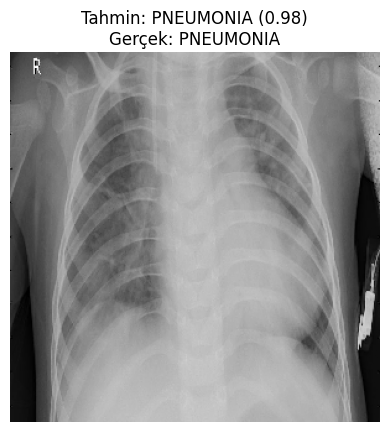

In [14]:

# 4. Test setinden bir örnek görüntü ve model tahmini
import random
import numpy as np
from tensorflow.keras.preprocessing import image

# Test klasör yolunu belirt
test_normal_dir = '/content/chest_xray_balanced/test/NORMAL'
test_pneumonia_dir = '/content/chest_xray_balanced/test/PNEUMONIA'

# Her iki sınıftan klasörleri birleştir
all_test_images = [os.path.join(test_normal_dir, f) for f in os.listdir(test_normal_dir)] + \
                  [os.path.join(test_pneumonia_dir, f) for f in os.listdir(test_pneumonia_dir)]

# Rastgele bir test görüntüsü seç
sample_path = random.choice(all_test_images)

# Görüntüyü yükle ve ön işle
img = image.load_img(sample_path, target_size=(299,299))
img_array = image.img_to_array(img) / 255.0
img_batch = np.expand_dims(img_array, axis=0)

# Tahmin yap
pred_prob = model.predict(img_batch)[0][0]
pred_class = "PNEUMONIA" if pred_prob > 0.5 else "NORMAL"

# Gerçek sınıfı yol üzerinden tahmin et
actual_class = "PNEUMONIA" if "PNEUMONIA" in sample_path else "NORMAL"

# Görseli ve sonucu göster
plt.imshow(img_array)
plt.axis('off')
plt.title(f"Tahmin: {pred_class} ({pred_prob:.2f})\nGerçek: {actual_class}")
plt.show()
